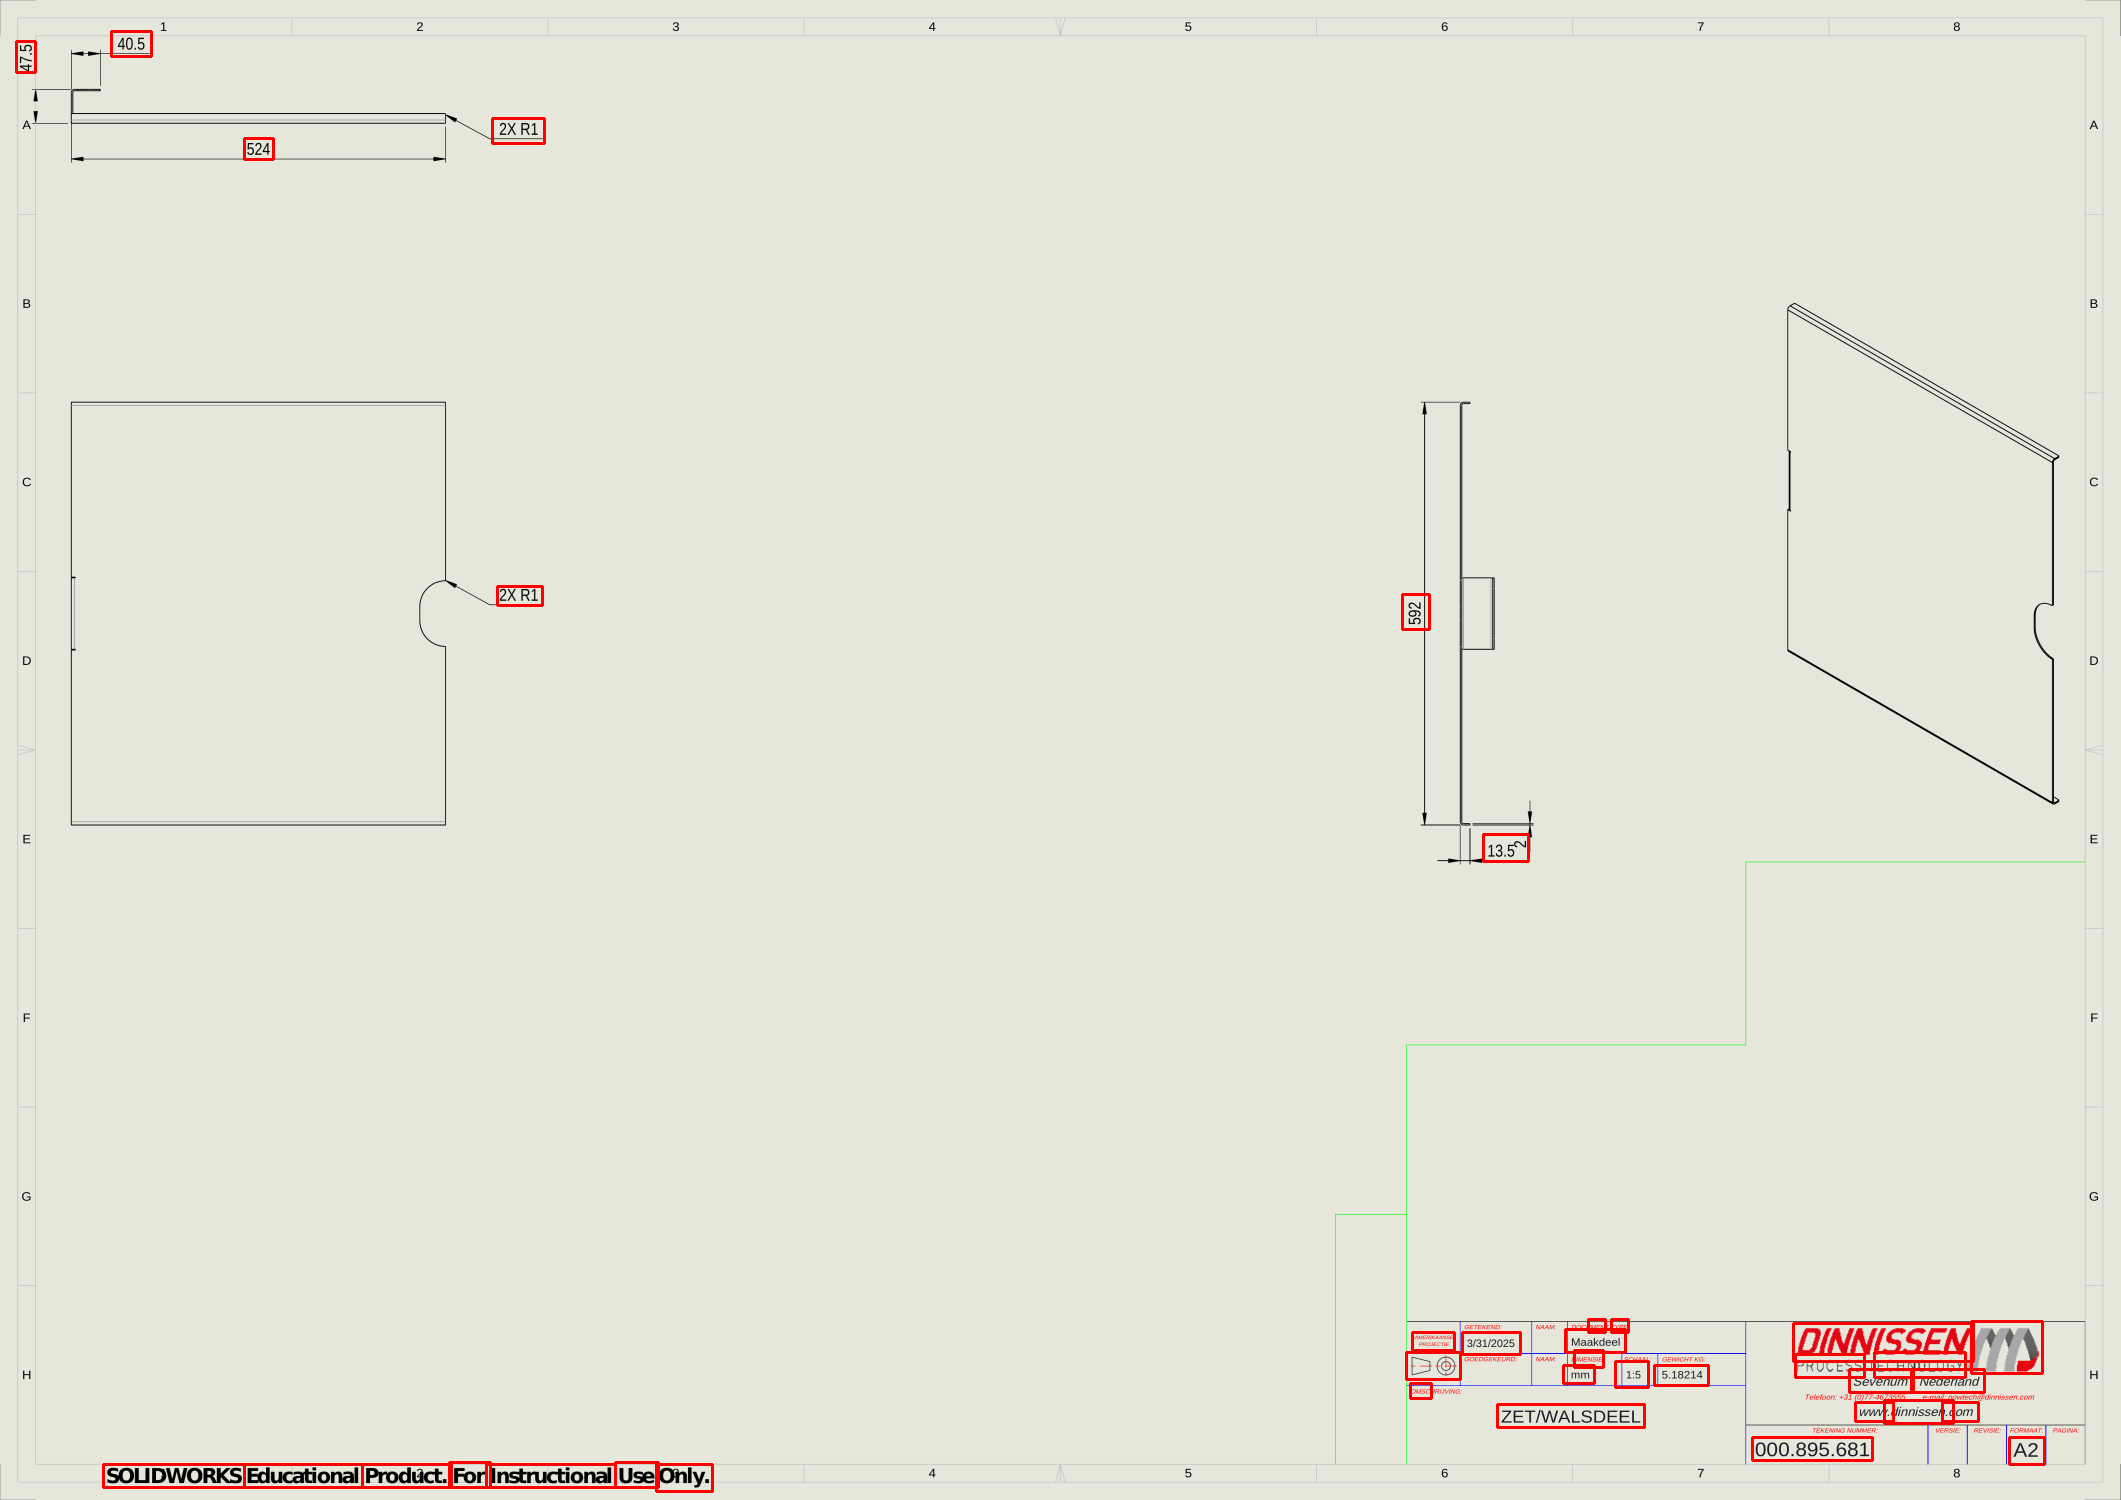

In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *
from template_extraction import *


# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
# f = "../../data/original/Good/300-014822.pdf"
# f = "../../data/original/Ugly/000.001.373.pdf"
# f = "../../data/original/Good/15316-100-D-020_Sheet2.pdf"
f = "../../data/original/Ugly/000.895.681.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

im_h, im_w, _ = img.shape
sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)
contours = detect_text_tables(img, words, mask)
title_contours = title_contours + contours

boundary = get_boundary(border_1, border_2, inner_border_lines)

for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

Image.fromarray(img_comp)

In [2]:
word_lines = words.drop_duplicates(subset=["line_idx"])

word_lines["line_geometry"] = word_lines.line_geometry.apply(
    lambda x: {"lx1": x[0][0], "ly1": x[0][1], "lx2": x[1][0], "ly2": x[1][1]}
)
word_lines = word_lines.join(pd.json_normalize(word_lines.pop('line_geometry')))

word_lines["lx1"] = word_lines["lx1"] * im_w
word_lines["lx2"] = word_lines["lx2"] * im_w
word_lines["ly1"] = word_lines["ly1"] * im_h
word_lines["ly2"] = word_lines["ly2"] * im_h

# word_lines = word_lines.loc[~word_lines.lx1.isna()]
mask = ~word_lines["lx1"].isna()
word_lines.loc[mask, ["x1", "y1", "x2", "y2"]] = word_lines.loc[mask, ["lx1", "ly1", "lx2", "ly2"]].values

word_lines.loc[~word_lines.lx1.isna()]

/tmp/ipykernel_8535/803576548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_lines["line_geometry"] = word_lines.line_geometry.apply(


,page_idx,dimensions,orientation.value,orientation.confidence,language.value,language.confidence,block_idx,block_geometry,objectness_score.lines,artefacts,...,crop_orientation.value,crop_orientation.confidence,x1,y1,x2,y2,lx1,ly1,lx2,ly2
index,,,,,,,,,,,,,,,,,,,,,
0,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,111.849609,31.262695,151.204102,56.118164,111.849609,31.262695,151.204102,56.118164
1,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,16.570312,41.619141,35.211914,72.688477,16.570312,41.619141,35.211914,72.688477
2,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,492.966797,118.256836,544.749023,143.112305,492.966797,118.256836,544.749023,143.112305
3,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,244.412109,138.969727,273.410156,159.682617,244.412109,138.969727,273.410156,159.682617
4,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,497.109375,586.368164,542.677734,605.009766,497.109375,586.368164,542.677734,605.009766
5,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,1402.262695,594.653320,1429.189453,629.865234,1402.262695,594.653320,1429.189453,629.865234
6,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,1483.042969,834.922852,1528.611328,861.849609,1483.042969,834.922852,1528.611328,861.849609
7,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,1588.678711,1319.604492,1628.033203,1332.032227,1588.678711,1319.604492,1628.033203,1332.032227
9,0,"(1500, 2121)",None,None,None,None,0,"((0.0078125, 0.020841796874999985), (0.9638671...",0.416858,[],...,0,None,1793.736328,1323.747070,1973.938477,1361.030273,1793.736328,1323.747070,1973.938477,1361.030273


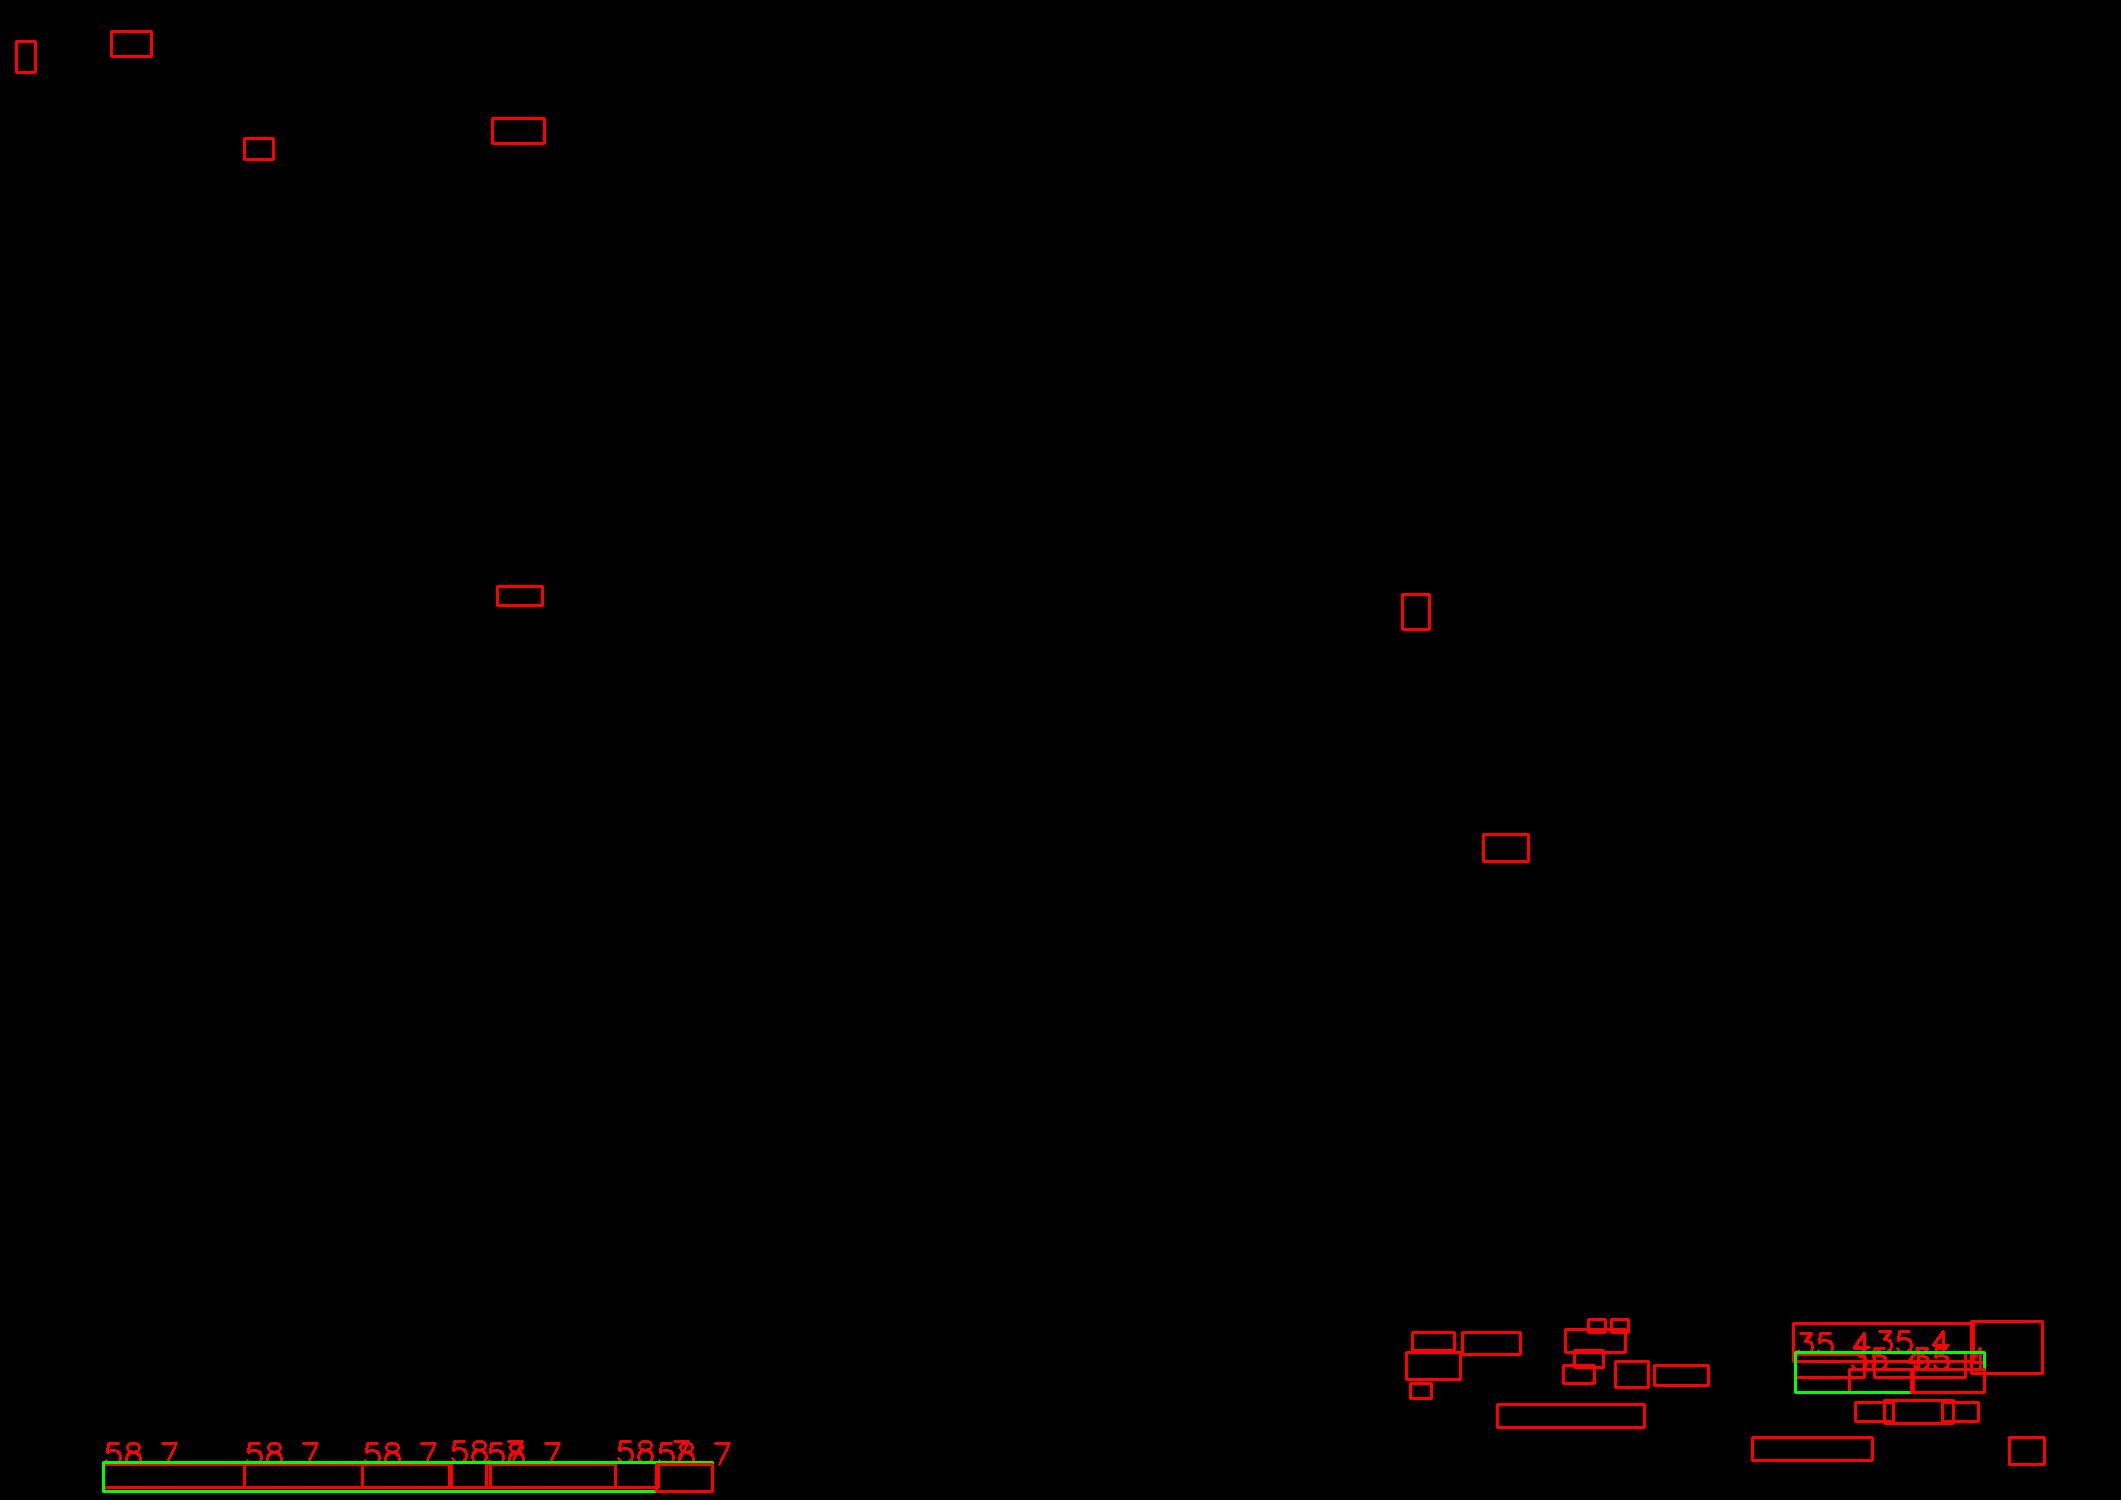

In [4]:
img_comp = np.zeros_like(img)
# print(words.line_geometry)
visited = []
line_boxes = []
for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    w, h = abs(bx1 - bx2), abs(by1 - by2)
    a_ratio = float(h) / float(w)
    area = abs(bx2 - bx1) * abs(by1 - by2)

    # if h < 50.0:
    #     cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (0, 255, 0), 2)
    # else:

    if row.line_idx not in visited:
        word_line = words.loc[words.line_idx == row.line_idx]
        x1, y1, x2, y2 = word_line["x1"].astype(int).min(), word_line["y1"].astype(int).min(), word_line["x2"].astype(int).max(), word_line["y2"].astype(int).max()

        sentence_words = word_line["value"].shape[0]
        sentence_chars = len(" ".join(word_line["value"].values))
        if sentence_words > 3 and sentence_chars > 10:
            cv2.putText(img_comp, f"{sentence_chars} {sentence_words}", (bx1, by1), font, fontScale, color, thickness)
            cv2.rectangle(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)
            line_boxes.append((x1, y1, x2, y2))

    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

Image.fromarray(img_comp)